In [1]:
import planetary_computer
from pystac_client import Client
import stackstac
import odc.stac
import geopandas
import numpy
import rich.table
import rasterio
import xarray

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image


In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [4]:
time_range = "2018-01-01/2018-12-31"
bbox = [100.35, 4.35, 100.85, 5.1]

search = catalog.search(collections=["landsat-8-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()

In [5]:
len(items)

68

In [6]:
roi_row = "057"
roi_path = "128"

found_sel_item = False
sel_item_cloud = 100

for item in items:
    if (item.properties["landsat:wrs_row"] == roi_row) and (item.properties["landsat:wrs_path"] == roi_path):
        if found_sel_item:
            if item.properties["eo:cloud_cover"] < sel_item_cloud:
                sel_item = item
                sel_item_cloud = item.properties["eo:cloud_cover"]
        else:
            sel_item = item
            found_sel_item = True
            sel_item_cloud = item.properties["eo:cloud_cover"]

print(sel_item.id)
    

LC08_L2SP_128057_20180630_02_T1


## Make a table of the scene assets because we can - see what is available

In [7]:
table = rich.table.Table("Asset Key", "Descripiption")
for asset_key, asset in sel_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key                 ┃ Descripiption                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ANG                       │ Angle Coefficients File                        │
│ SR_B1                     │ Coastal/Aerosol Band (B1)                      │
│ SR_B2                     │ Blue Band (B2)                                 │
│ SR_B3                     │ Green Band (B3)                                │
│ SR_B4                     │ Red Band (B4)                                  │
│ SR_B5                     │ Near Infrared Band 0.8 (B5)                    │
│ SR_B6                     │ Short-wave Infrared Band 1.6 (B6)              │
│ SR_B7                     │ Short-wave Infrared Band 2.2 (B7)              │
│ ST_QA                     │ Surface Temperature Quality Assessment Band    │
│ ST_B10                    │ Surface Temperature Band (B10)                 │
│ MTL.txt                   │ Product Metadata File                          │
│ MTL.xml                   │ Product Metadata File (xml)                    │
│ ST_DRAD                   │ Downwelled Radiance Band                       │
│ ST_EMIS                   │ Emissivity Band                                │
│ ST_EMSD                   │ Emissivity Standard Deviation Band             │
│ ST_TRAD                   │ Thermal Radiance Band                          │
│ ST_URAD                   │ Upwelled Radiance Band                         │
│ MTL.json                  │ Product Metadata File (json)                   │
│ QA_PIXEL                  │ Pixel Quality Assessment Band                  │
│ ST_ATRAN                  │ Atmospheric Transmittance Band                 │
│ ST_CDIST                  │ Cloud Distance Band                            │
│ QA_RADSAT                 │ Radiometric Saturation Quality Assessment Band │
│ thumbnail                 │ Thumbnail image                                │
│ SR_QA_AEROSOL             │ Aerosol Quality Analysis Band                  │
│ reduced_resolution_browse │ Reduced resolution browse image                │
│ tilejson                  │ TileJSON with default rendering                │
│ rendered_preview          │ Rendered preview                               │
└───────────────────────────┴────────────────────────────────────────────────┘

In [8]:
sel_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-8-c2-l2&item=LC08_L2SP_128057_20180630_02_T1&assets=SR_B4&assets=SR_B3&assets=SR_B2&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

In [9]:
Image(url=sel_item.assets["rendered_preview"].href, width=500)

## Sign the item so we can get urls to do work...

In [10]:
sel_item_signed = planetary_computer.sign(sel_item)


## Functions taken from RSGISLib for stretching image data for visualisation

In [11]:
def limit_range_np_arr(
    arr_data: numpy.array,
    min_thres: float = 0,
    min_out_val: float = 0,
    max_thres: float = 1,
    max_out_val: float = 1,
) -> numpy.array:
    """
    A function which can be used to limit the range of the numpy array.
    For example, to mask values less than 0 to 0 and values greater than
    1 to 1.

    :param arr_data: input numpy array.
    :param min_thres: the threshold for the minimum value.
    :param min_out_val: the value assigned to values below the min_thres
    :param max_thres: the threshold for the maximum value.
    :param max_out_val: the value assigned to the values above the max_thres
    :return: numpy array with output values.

    """
    arr_data_out = arr_data.copy()
    arr_data_out[arr_data < min_thres] = min_out_val
    arr_data_out[arr_data > max_thres] = max_out_val
    return arr_data_out


def cumulative_stretch_np_arr(
    arr_data: numpy.array,
    no_data_val: float = None,
    lower: int = 2,
    upper: int = 98,
    out_off: float = 0,
    out_gain: float = 1,
    out_int_type=False,
    min_out_val: float = 0,
    max_out_val: float = 1,
) -> numpy.array:
    """
    A function which performs a cumulative stretch using an upper and lower
    percentile to define the min-max values. This analysis is on a per
    band basis for a numpy array representing an image dataset. This function
    is useful in combination with get_gdal_raster_mpl_imshow for displaying
    raster data from an input image as a plot. By default this function returns
    values in a range 0 - 1 but if you prefer 0 - 255 then set the out_gain to
    255 and the out_int_type to be True to get an 8bit unsigned integer value.

    :param arr_data: The numpy array as either [n,m,b] or [n,m] where n and m are
                     the number of image pixels in the x and y axis' and b is the
                     number of image bands.
    :param no_data_val: the no data value for the input data. If there isn't a no
                        data value then leave as None (default)
    :param lower: lower percentile (default: 2)
    :param upper: upper percentile (default: 98)
    :param out_off: Output offset value (value * gain) + offset. Default: 0
    :param out_gain: Output gain value (value * gain) + offset. Default: 1
    :param out_int_type: False (default) and the output type will be float and
                         True and the output type with be integers.
    :param min_out_val: Minimum output value within the output array (default: 0)
    :param max_out_val: Maximum output value within the output array (default: 1)
    :return: A number array with the rescaled values but same dimensions as the
             input numpy array.

    .. code:: python

        img_sub_bbox = [554756, 577168, 9903924, 9944315]
        input_img = "sen2_img_strch.kea"

        img_data_arr, coords_bbox = get_gdal_raster_mpl_imshow(input_img,
                                                               bands=[8,9,3],
                                                               bbox=img_sub_bbox)

        img_data_arr = cumulative_stretch_np_arr(img_data_arr, no_data_val=0.0)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        im = ax.imshow(img_data_arr, extent=coords_bbox)
        plt.show()

    """
    arr_shp = arr_data.shape

    if no_data_val is not None:
        arr_data_out = arr_data.astype(float)
        arr_data_out[arr_data == no_data_val] = numpy.nan
    else:
        arr_data_out = arr_data.copy()

    if len(arr_shp) == 2:
        min_val, max_val = numpy.nanpercentile(arr_data_out, [lower, upper])
        range_val = max_val - min_val

        arr_data_out = (((arr_data_out - min_val) / range_val) * out_gain) + out_off
    else:
        n_bands = arr_shp[2]
        for n in range(n_bands):
            min_val, max_val = numpy.nanpercentile(arr_data_out[..., n], [lower, upper])
            range_val = max_val - min_val

            arr_data_out[..., n] = (
                ((arr_data_out[..., n] - min_val) / range_val) * out_gain
            ) + out_off

    arr_data_out = limit_range_np_arr(
        arr_data_out,
        min_thres=min_out_val,
        min_out_val=min_out_val,
        max_thres=max_out_val,
        max_out_val=max_out_val,
    )

    if out_int_type:
        arr_data_out = arr_data_out.astype(int)

    return arr_data_out

In [12]:
def expand_ls_qa_pixel_msks(scn_xa, qa_pxl_msk="QA_PIXEL"):
    unq_img_vals = numpy.unique(numpy.squeeze(scn_xa["QA_PIXEL"].values))
    
    fill_da = scn_xa["QA_PIXEL"].copy()
    fill_da[...] = 0
    fill_da = fill_da.astype(numpy.uint8)
    
    dilated_clouds_da = scn_xa["QA_PIXEL"].copy()
    dilated_clouds_da[...] = 0
    dilated_clouds_da = dilated_clouds_da.astype(numpy.uint8)
    
    cirrus_da = scn_xa["QA_PIXEL"].copy()
    cirrus_da[...] = 0
    cirrus_da = cirrus_da.astype(numpy.uint8)
    
    clouds_da = scn_xa["QA_PIXEL"].copy()
    clouds_da[...] = 0
    clouds_da = clouds_da.astype(numpy.uint8)
    
    cloud_shadows_da = scn_xa["QA_PIXEL"].copy()
    cloud_shadows_da[...] = 0
    cloud_shadows_da = cloud_shadows_da.astype(numpy.uint8)
    
    snow_da = scn_xa["QA_PIXEL"].copy()
    snow_da[...] = 0
    snow_da = snow_da.astype(numpy.uint8)
    
    clear_da = scn_xa["QA_PIXEL"].copy()
    clear_da[...] = 0
    clear_da = clear_da.astype(numpy.uint8)
    
    water_da = scn_xa["QA_PIXEL"].copy()
    water_da[...] = 0
    water_da = water_da.astype(numpy.uint8)
    
    all_clouds_da = scn_xa["QA_PIXEL"].copy()
    all_clouds_da[...] = 0
    all_clouds_da = all_clouds_da.astype(numpy.uint8)
    
    for val in unq_img_vals:
        val_bin = numpy.flip(numpy.unpackbits(numpy.flip(numpy.array([val]).view(numpy.uint8))))
        #print("{} = {}".format(val, val_bin))
        if val_bin[0] == 1:
            fill_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[1] == 1:
            dilated_clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[2] == 1:
            cirrus_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[3] == 1:
            clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[4] == 1:
            cloud_shadows_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[5] == 1:
            snow_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[6] == 1:
            clear_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[7] == 1:
            water_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if (val_bin[1] == 1) or (val_bin[2] == 1) or (val_bin[3] == 1) or (val_bin[4] == 1):
            all_clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
    
    scn_xa["FILL"]=fill_da
    scn_xa["DILATED_CLOUDS"]=dilated_clouds_da
    scn_xa["CIRRUS"]=cirrus_da
    scn_xa["CLOUDS"]=clouds_da
    scn_xa["CLOUD_SHADOWS"]=cloud_shadows_da
    scn_xa["SNOW"]=snow_da
    scn_xa["CLEAR"]=clear_da
    scn_xa["WATER"]=water_da
    scn_xa["ALL_CLOUDS"]=all_clouds_da

# Read the data into an xarray

Just reading the single item so add to list - note the item is already signed.

In [13]:
bands = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "QA_PIXEL"]
ls8_scn_xa = odc.stac.load([sel_item_signed], bands=bands)

In [14]:
ls8_scn_xa

<xarray.Dataset>
Dimensions:      (time: 1, y: 7732, x: 7572)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-30T03:33:25.534703
  * y            (y) float64 5.952e+05 5.952e+05 ... 3.633e+05 3.633e+05
  * x            (x) float64 5.118e+05 5.118e+05 ... 7.389e+05 7.389e+05
    spatial_ref  int32 32647
Data variables:
    SR_B1        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B2        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B3        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B4        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B5        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B6        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B7        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    QA_PIXEL     (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

## Expand the landsat QA mask(s)

In [15]:
expand_ls_qa_pixel_msks(ls8_scn_xa, qa_pxl_msk="QA_PIXEL")

In [16]:
ls8_scn_xa

<xarray.Dataset>
Dimensions:         (time: 1, y: 7732, x: 7572)
Coordinates:
  * time            (time) datetime64[ns] 2018-06-30T03:33:25.534703
  * y               (y) float64 5.952e+05 5.952e+05 ... 3.633e+05 3.633e+05
  * x               (x) float64 5.118e+05 5.118e+05 ... 7.389e+05 7.389e+05
    spatial_ref     int32 32647
Data variables: (12/17)
    SR_B1           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SR_B2           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SR_B3           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SR_B4           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SR_B5           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SR_B6           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ...              ...
    CLOUDS          (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    CLOUD_SHADOWS   (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    SNOW            (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    CLEAR           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    WATER           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ALL_CLOUDS      (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

## Apply cloud and valid mask

In [17]:
for band in bands[:-1]:
    ls8_scn_xa[band].values[ls8_scn_xa["ALL_CLOUDS"].values == 1] = 0.0
    ls8_scn_xa[band].values[ls8_scn_xa["FILL"].values == 1] = 0.0

## Visualise the image data

Not sure if this is really the best way to do it but it works...

In [18]:
band_stack = numpy.vstack([ls8_scn_xa["SR_B5"].values, ls8_scn_xa["SR_B6"].values, ls8_scn_xa["SR_B4"].values])
band_stack.shape
band_stack = numpy.moveaxis(band_stack, 0, -1)
band_stack_stch = cumulative_stretch_np_arr(band_stack, no_data_val=0.0)

In [19]:
img_bbox = [float(ls8_scn_xa.x.min()), float(ls8_scn_xa.x.max()), float(ls8_scn_xa.y.min()), float(ls8_scn_xa.y.max())]
img_bbox

[511785.0, 738915.0, 363285.0, 595215.0]

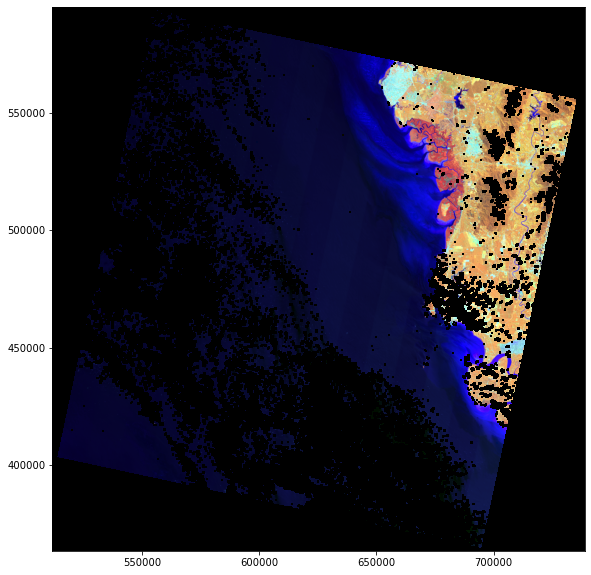

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_stack_stch, extent=img_bbox)

# BELOW WAS JUST WORKING THINGS OUT...

# Try Reading Cloud Distance and QA Data

In [ ]:
def create_ls_qa_pixel_msks(scn_xa, qa_pxl_msk="QA_PIXEL"):
    unq_img_vals = numpy.unique(numpy.squeeze(scn_xa["QA_PIXEL"].values))
    
    fill_da = scn_xa["QA_PIXEL"].copy()
    fill_da[...] = 0
    fill_da = fill_da.astype(numpy.uint8)
    
    dilated_clouds_da = scn_xa["QA_PIXEL"].copy()
    dilated_clouds_da[...] = 0
    dilated_clouds_da = dilated_clouds_da.astype(numpy.uint8)
    
    cirrus_da = scn_xa["QA_PIXEL"].copy()
    cirrus_da[...] = 0
    cirrus_da = cirrus_da.astype(numpy.uint8)
    
    clouds_da = scn_xa["QA_PIXEL"].copy()
    clouds_da[...] = 0
    clouds_da = clouds_da.astype(numpy.uint8)
    
    cloud_shadows_da = scn_xa["QA_PIXEL"].copy()
    cloud_shadows_da[...] = 0
    cloud_shadows_da = cloud_shadows_da.astype(numpy.uint8)
    
    snow_da = scn_xa["QA_PIXEL"].copy()
    snow_da[...] = 0
    snow_da = snow_da.astype(numpy.uint8)
    
    clear_da = scn_xa["QA_PIXEL"].copy()
    clear_da[...] = 0
    clear_da = clear_da.astype(numpy.uint8)
    
    water_da = scn_xa["QA_PIXEL"].copy()
    water_da[...] = 0
    water_da = water_da.astype(numpy.uint8)
    
    all_clouds_da = scn_xa["QA_PIXEL"].copy()
    all_clouds_da[...] = 0
    all_clouds_da = all_clouds_da.astype(numpy.uint8)
    
    for val in unq_img_vals:
        val_bin = numpy.flip(numpy.unpackbits(numpy.flip(numpy.array([val]).view(numpy.uint8))))
        #print("{} = {}".format(val, val_bin))
        if val_bin[0] == 1:
            fill_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[1] == 1:
            dilated_clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[2] == 1:
            cirrus_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[3] == 1:
            clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[4] == 1:
            cloud_shadows_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[5] == 1:
            snow_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[6] == 1:
            clear_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if val_bin[7] == 1:
            water_da.values[scn_xa["QA_PIXEL"].values == val] = 1
        if (val_bin[1] == 1) or (val_bin[2] == 1) or (val_bin[3] == 1) or (val_bin[4] == 1):
            all_clouds_da.values[scn_xa["QA_PIXEL"].values == val] = 1
    
    scn_xa["fill"]=fill_da
    scn_xa["dilated_clouds"]=dilated_clouds_da
    scn_xa["cirrus"]=cirrus_da
    scn_xa["clouds"]=clouds_da
    scn_xa["cloud_shadows"]=cloud_shadows_da
    scn_xa["snow"]=snow_da
    scn_xa["clear"]=clear_da
    scn_xa["water"]=water_da
    scn_xa["all_clouds"]=all_clouds_da

In [ ]:
bands = ["QA_PIXEL"]
ls8_scn_qa_xa = odc.stac.load([sel_item_signed], bands=bands)

In [ ]:
ls8_scn_qa_xa

In [ ]:
create_ls_qa_pixel_msks(ls8_scn_qa_xa, qa_pxl_msk="QA_PIXEL")

In [ ]:
ls8_scn_qa_xa

In [ ]:
ls8_scn_qa_xa.all_clouds[0].plot.imshow(figsize=(15,10))

In [ ]:
#numpy.unique(numpy.squeeze(ls8_scn_qa_xa["QA_PIXEL"].values))

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(numpy.squeeze(ls8_scn_qa_xa["QA_PIXEL"].values), extent=img_bbox)

In [ ]:
#ls_qa_pixels = numpy.squeeze(ls8_scn_qa_xa["QA_PIXEL"].values)

In [ ]:
#ls_qa_pixels

In [ ]:
#vals = numpy.unique(ls_qa_pixels)

In [ ]:
#vals

In [ ]:
#numpy.unpackbits(vals.view(numpy.uint8))
#vals_uint8 = vals.view(numpy.uint8)
#vals_uint8

In [ ]:
vals_uint8.shape

In [ ]:
vals.shape

In [ ]:
for i in range(vals.shape[0]):
    qa_arr = numpy.unpackbits(numpy.flip(numpy.array([vals[i]]).view(numpy.uint8)))
    print("{} = {}".format(vals[i], qa_arr))
    if qa_arr[0] == 
